# Preliminary Analysis of CMM Data

This notebook provides some very preliminary analysis for coordinate measuring machine (CMM) data collected from a variant of the NIST multi-pin layout that has been augmented with additional (randomly configured) pins.  In particular, it provides some basic visualization of the data that we will use to guide our GP modeling efforts.

The first few sections are just Python setup and loading the CMM data.  If you are just browsing this notebook on the web, feel free to skip down to section 1.

## Section 0: Python setup

In [9]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

__author__ = "mjp"
__version__ = "0.0.1"
__status__ = "development"

__copyright__ = "Copyright 2016, JHU/APL"
__license__ = "Apache, Version 2.0"

import os, csv

import numpy as np
import pylab as plt
from mpl_toolkits.mplot3d import axes3d, art3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Some helper functions for loading and visualizing data

def load_data(fn):
    """Loads data set from CSV file.
       fn : The .csv file to load.  Format is assumed to be:
            xNominal, xMeasured, yNominal, yMeasured, dNominal, dMeasured, zNominal, zMeasured
            
            where x, y, d, z are pin x-position, y-position, diameter and height.
    """
    Z = []

    cast = lambda row: [row[0].strip(),] + [float(x) for x in row[1:]]
    
    with open(fn, 'rU') as f:
        reader = csv.reader(f, delimiter=',')
        for rowIdx, row in enumerate(reader):
            if rowIdx == 0: continue # skip header
                
            pinId, xNom, xMeas, yNom, yMeas, dNom, dMeas, zNom, zMeas = cast(row)
            Z.append((xNom, xMeas, yNom, yMeas, dNom, dMeas, zNom, zMeas))

    return np.array(Z)


def cart2polar(x, y):
    "Cartesian to polar coordinates."
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r[:,np.newaxis], theta[:,np.newaxis]


def stem3c(ax, x, y, z):
    "Colored 3d stem plot (similar to matlab's stem3())"
    ax.scatter(x, y, z, 'k')
    
    for ii in range(len(x)):
        color = 'green' if z[ii] >= 0 else 'blue'

        line = art3d.Line3D((x[ii], x[ii]),
                            (y[ii], y[ii]),
                            (0, z[ii]),
                            color=color)
        ax.add_line(line)
            

<IPython.core.display.Javascript object>


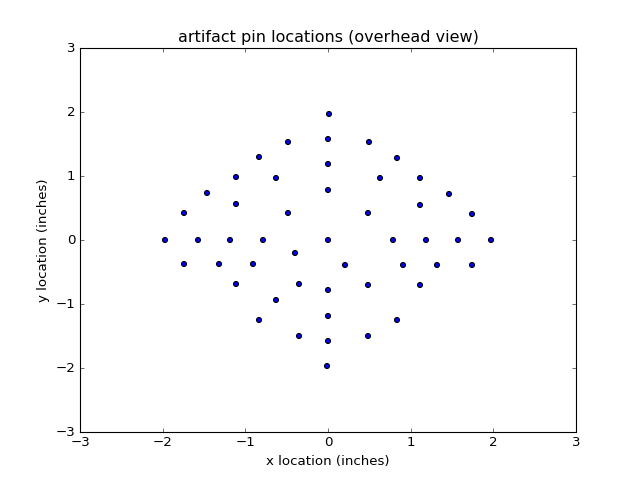

In [11]:
inDir = os.path.join('..', 'data')
inFile = os.path.join(inDir, 'NIST_randomized_metal_no1.csv')
Z = load_data(inFile)

# extract data of interest
# The measured variables wear hats.
x = Z[:,0];  y = Z[:,2]
xHat = Z[:,1];  yHat = Z[:,3]
d = Z[:,4];  dHat = Z[:,5];
z = Z[:,6];  zHat = Z[:,7];

r, theta = cart2polar(x,y)
rHat, thetaHat = cart2polar(xHat, yHat)

plt.scatter(x, y)
plt.title('artifact pin locations (overhead view)')
plt.xlabel('x location (inches)')
plt.ylabel('y location (inches)')

## Section 1.0: Analysis of Pin Location Error

As a first step, we ask whether pin location error (in the $x$ and $y$ directions separately) seems to be a function of the absolute location.  From the plots below, one observes a clear linear trend in the $x$ and $y$ errors (where error is defined as the measured value minus the designed/nominal value).  

**However**, one interesting observation is that $\delta x$ (error in $x$ dimension) seems to be predominantly a function of $y$ and vice versa. Naively one might have expected $\delta x, \delta y$ to be driven solely by distance from the origin; alternatively, perhaps $\delta x$ would be primarily a function of $x$ and exhibit only a weak dependence upon $y$ (e.g. as was observed in Brotan "A new method for determining and improving the accurace of power bed additive manufacturing machine," 2014).  Barring some error in transcribing the measurements, this does not appear to be the case here.

<IPython.core.display.Javascript object>


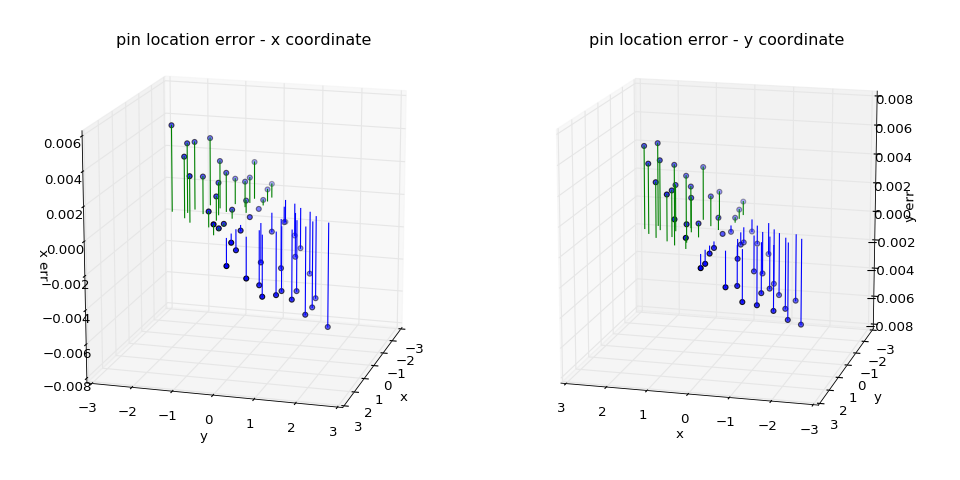

In [12]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
stem3c(ax, x, y, xHat-x)
ax.view_init(elev=16, azim=16)
ax.set_zlabel('x err')
plt.xlabel('x'); plt.ylabel('y'); 
plt.title('pin location error - x coordinate')
    
ax = fig.add_subplot(122, projection='3d')
stem3c(ax, x, y, yHat-y)
ax.view_init(elev=15, azim=105)
ax.set_zlabel('y err')
plt.xlabel('x'); plt.ylabel('y'); 
plt.title('pin location error - y coordinate')
plt.tight_layout()

## Section 1.1: Analysis of Pin Location Error - An Alternate View

Using the same data from section 1.0, we now consider $\delta x, \delta y$ as functions of $r, \theta$ by switching to polar coordinates.  Note that we can also consider errors in this new coordinate system (i.e. $\delta r, \delta \theta$); however, it will turn out to be more illustrative to consider cartesian errors.  When examining these new plots, it becomes clear that $\delta x$ is strongly influenced by both $r$ and $\theta$; in particular, $\delta x$ is large precisely when $r$ is not small **and** $\theta$ is close to $\pm \frac{\pi}{2}$.  If one rotates the plot so that the $r$ dimension is coming out of the page, one observes an almost sinusoidal pattern to the $\delta x$.  

Similarly, $\delta y$ is large when $r$ is not negligible **and** $\theta$ is approximately $0 \pm 2 \pi$.  Rotating the plot so that $r$ comes out of the page, one observes errors that qualitatively look like a plot of $\cos (\theta)$.

Assuming this is not some artifact of data processing, a natural question is what causes this almost periodic dependence of error upon the angle $\theta$.  A natural next step is to consult with our domain experts to see if this phenonema is consistent with their understanding of the laser and mirrors system used on this AM device and/or the mechanism by which the CMM system gatheres measurements.

<IPython.core.display.Javascript object>


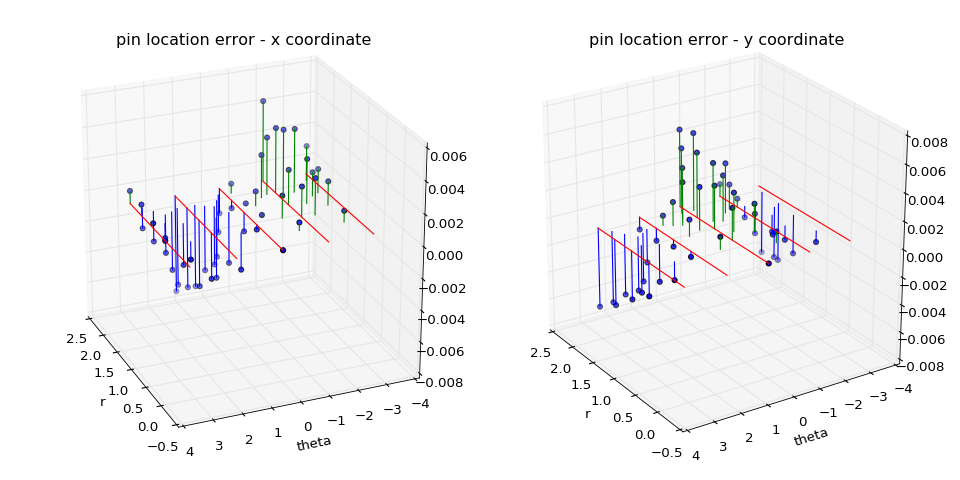

In [13]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
stem3c(ax, r, theta, xHat-x)
for tLine in [-np.pi, -np.pi/2., 0, np.pi/2., np.pi]:
    line = art3d.Line3D((np.min(r), np.max(r)),
                        (tLine, tLine),
                        (0,0),
                        color='red')
    ax.add_line(line)
ax.view_init(elev=25, azim=157)
plt.xlabel('r'); plt.ylabel('theta'); 
plt.title('pin location error - x coordinate')

     
ax = fig.add_subplot(122, projection='3d')
stem3c(ax, r, theta, yHat-y)
for tLine in [-np.pi, -np.pi/2., 0, np.pi/2., np.pi]:
    line = art3d.Line3D((np.min(r), np.max(r)),
                        (tLine, tLine),
                        (0,0),
                        color='red')
    ax.add_line(line)
ax.view_init(elev=25, azim=147)
plt.xlabel('r'); plt.ylabel('theta'); 
plt.title('pin location error - y coordinate')
plt.tight_layout()